# New function:
1-add SEI growth at CC end and CD end, so that to compared SEI growth during charge and discharge.  which Charles may be interested in!

2-add plots for Li+ and EC contents to check conservation

3-complete post-processing scripts in functions for IC-HPC 

4-make title 2 rows to avoid overlapping



In [1]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;
import matplotlib as mpl; from textwrap import wrap
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
    RioCallback,
    recursive_scan,
    Para_init,
    write_excel_xlsx,
    Run_P3_model,
    Plot_Last_Single_Step,
    GetSol_dict,
    Plot_Loc_Var_2,
    Plot_Fig_1,
    Plot_Loc_Var_sol_6,
)

from pybamm import tanh,exp,sqrt
def electrolyte_conductivity_Valoen2005Constant(c_e,c_EC, T):# Mark Ruihe change
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    # mS/cm to S/m
    return sigma
def electrolyte_conductivity_Valoen2005Constant_EC_Haya(c_e,c_EC, T):
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    a=1.092; b=-6.497e-6; c=-0.7877; d=-0.0004808
    ratio= (
        a*exp(b*c_EC)+c*exp(d*c_EC) )
    return sigma*ratio
def electrolyte_conductivity_Valoen2005Constant_ECtanh500_1(c_e,c_EC, T):# Mark Ruihe change
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    coff = 1
    ratio = ( (1-coff)+ coff/2 + coff/2 *  tanh((c_EC-4500*0.5)/500))
    return sigma*ratio

In [3]:
########################  Input  ########################
# all values here must be a list, even it is a single object
Para_dict_All = {
   "Total ageing cycles":[30,],
   "SaveAsList":[  [10,5,1,1,1,1],  ],
   "Ageing temperature":[25,],
   #"Particle mesh points":[120,],
   #"Exponential mesh stretch":[2.3,],
   "Para_Set":[ "Li2023_ECdrag",],
    "Model option":[
        {
            "calculate discharge energy":"true",
            "SEI":"solvent-diffusion limited",      
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",     
            "solvent diffusion": "double spatial consume w refill"   },
    ],
   # solvent diffusion parameters:
   "EC transference number":[-1.4,],
   "Cation transference number":[0.28,],
   "EC Lithium ion cross diffusivity [m2.s-1]":[3e-11,],
   "EC diffusivity in electrolyte [m2.s-1]":[5e-10,5e-5],

   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],
   #"Negative electrode diffusivity [m2.s-1]":[2e-13,],
   #"Positive electrode diffusivity [m2.s-1]":[1e-13,],
   # if want a function, add 'Func', 
   #    if want a constant, delete Func
   # note!!!: Constant will overwrite Func
   "Func Electrolyte conductivity [S.m-1]":[
        "electrolyte_conductivity_Valoen2005Constant",
        ],
    "Func Electrolyte diffusivity [m2.s-1]":[
        "electrolyte_diffusivity_Valoen2005Constant",],
   # general SEI
   'SEI resistivity [Ohm.m]':[2E5,],
   "Ratio of lithium moles to SEI moles":[2,],
   "Inner SEI reaction proportion":[0.5,],
   "Initial inner SEI thickness [m]":[2.5e-9,],
   "Initial outer SEI thickness [m]":[2.5e-9,],
   # solvent-diffusion limited
   'Outer SEI solvent diffusivity [m2.s-1]':[1.7e-22,],
   'Bulk solvent concentration [mol.m-3]':[4541.0,],
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[3e-20,],    
   'Lithium interstitial reference concentration [mol.m-3]':[15,],
   # ec-reaction limited
   'EC diffusivity in SEI [m2.s-1]':[5e-21],
   'SEI kinetic rate constant [m.s-1]':[1e-12,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})

In [4]:
print(len(Para_dict_list))

2


In [5]:
keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Negative electrode porosity",
    "CCend Positive electrode potential [V]",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend EC concentration [mol.m-3]",
    "CCend c(EC) over c(Li+)",
    "CCend Electrolyte current density [A.m-2]",
    "CCend Electrolyte diffusivity [m2.s-1]",
    "CCend Electrolyte conductivity [S.m-1]",
    "CCend Negative electrode SEI interfacial current density [A.m-2]",

    "CDend Negative electrode porosity",
    "CDend Positive electrode potential [V]",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend EC concentration [mol.m-3]",
    "CDend c(EC) over c(Li+)",
    "CDend Electrolyte current density [A.m-2]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
    "CDend Negative electrode SEI interfacial current density [A.m-2]",

]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CC Time [h]",
    "CV Time [h]",
    "CD Terminal voltage [V]",
    "CC Terminal voltage [V]",
    "CV Terminal voltage [V]",
]
keys_cyc_AGE = [   # default: CDend
    "Discharge capacity [A.h]",
    "CDsta Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CCsta Loss of capacity to SEI [A.h]",
    "CCend Loss of capacity to SEI [A.h]",
    "CVsta Loss of capacity to SEI [A.h]",
    "CVend Loss of capacity to SEI [A.h]",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode SOC", 
    "CDend Negative electrode SOC",
    "CDsta Positive electrode SOC", 
    "CDend Positive electrode SOC",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    "CDend Loss of active material in positive electrode [%]",
    "CDend Loss of active material in negative electrode [%]",
    "CDend Total EC in electrolyte [mol]",
    "CDend Total EC in electrolyte and SEI [mol]",
    "CDend Total lithium in electrolyte [mol]",
    "CDend Total lithium in particles [mol]",

]
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];

In [6]:
# define experiments and scan!
V_max = 4.2;        V_min = 2.5; 
exp_AGE = [
   (f"Discharge at 1 C until {V_min} V", 
   f"Charge at 1 C until {V_max} V",  # (5 minute period)
   f"Hold at {V_max} V until C/20"),  ]# (5 minute period)
exp_AGE_2 = [
   (f"Discharge at 1 C until {V_min} V (5 seconds period)", 
   f"Charge at 1 C until {V_max} V (5 seconds period)", 
   f"Hold at {V_max} V until C/20 (5 seconds period)"),]
# step index for ageing
exp_AGE_CD = [ (
   f"Discharge at 1 C until {V_min} V (1 seconds period)",   ) ]
exp_AGE_CC = [ (
   f"Charge at 1 C until {V_max} V (1 seconds period)" ) ]
exp_AGE_CV = [ (
   f"Hold at {V_max} V until C/20 (1 seconds period)" ) ]
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

Exp_AGE_List     = [
    exp_AGE,exp_AGE,exp_AGE_2,
    exp_AGE_CD,exp_AGE_CC,exp_AGE_CV];
cycle_no = -1; 
exp_index_pack = [
   cycle_no,step_AGE_CD,
   step_AGE_CC,step_AGE_CV,];
# Path and save to excel
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R9/'; 
Target  = 'c_4_5_sol_SEIcheck/' # wip\Rio_Code\P3R10\.ipynb
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
book_name_xlsx = 'c_4_5.xlsx';sheet_name_xlsx = 'Results';
Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];
# Write the head for excel file:
head_list = list(Para_dict_list[0].keys())
head_list.insert(0,"Index");
head_list.extend([ "exp_AGE_text", 
   "Cap Loss","LLI to SEI",
   "LAM to Neg","LAM to Pos",
   "Error"])
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, [head_list])

###########################################        
#                Scan                     #
###########################################  
Index = np.arange(1,len(Para_dict_list)+1)  
""" for Para_dict_i,index_i in zip(Para_dict_list,Index):
   Sol_all_i,j,midc_merge = Run_P3_model(
      index_i, Para_dict_i,   Path_pack , 
      keys_all_AGE,   Exp_AGE_List, exp_index_pack 
   )   """ 
if __name__ == "__main__":
    pool = multiprocessing.Pool(2)
    processes = [pool.apply_async(
        Run_P3_model, 
        args=(
            index_i, Para_dict_i,   Path_pack , 
            keys_all_AGE,   Exp_AGE_List, exp_index_pack 
         )   ) 
         for Para_dict_i,index_i in zip(Para_dict_list,Index)]
    result = [p.get() for p in processes] 

   

Successfully create a excel file


In [13]:
Sol_all_i,j,midc_merge = result[0];
Sol_all_2,j2,midc_merge2 = result[1];

In [8]:
print(
    Sol_all_i[-1].cycles[-1].steps[0]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[-1].cycles[-1].steps[0]["Loss of capacity to SEI [A.h]"].entries[0]  
)
print(
    Sol_all_i[-1].cycles[-1].steps[1]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[-1].cycles[-1].steps[1]["Loss of capacity to SEI [A.h]"].entries[0]
) 
print(
    Sol_all_i[-1].cycles[-1].steps[2]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[-1].cycles[-1].steps[2]["Loss of capacity to SEI [A.h]"].entries[0]
) 


print(
    Sol_all_i[-1].cycles[-1].steps[0]["Time [h]"].entries[-1] - 
    Sol_all_i[-1].cycles[-1].steps[0]["Time [h]"].entries[0]  
)
print(
    Sol_all_i[-1].cycles[-1].steps[1]["Time [h]"].entries[-1] - 
    Sol_all_i[-1].cycles[-1].steps[1]["Time [h]"].entries[0]
) 
""" print(
    #Sol_all_i[0].cycles[0].steps[0]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[0].cycles[0].steps[0]["X-averaged SEI interfacial current density [A.m-2]"].entries  
)
print(
    #Sol_all_i[0].cycles[0].steps[1]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[0].cycles[0].steps[1]["X-averaged SEI interfacial current density [A.m-2]"].entries
) """

0.00036632238079788854
0.00029363957021931453
0.0003846840491208148
0.9729632246163753
0.6723614803340006


' print(\n    #Sol_all_i[0].cycles[0].steps[0]["Loss of capacity to SEI [A.h]"].entries[-1] - \n    Sol_all_i[0].cycles[0].steps[0]["X-averaged SEI interfacial current density [A.m-2]"].entries  \n)\nprint(\n    #Sol_all_i[0].cycles[0].steps[1]["Loss of capacity to SEI [A.h]"].entries[-1] - \n    Sol_all_i[0].cycles[0].steps[1]["X-averaged SEI interfacial current density [A.m-2]"].entries\n) '

In [9]:
from textwrap import wrap
def Plot_Loc_Var_sol( sol,x_loc_all, key_all, cycle, step,colormap,fs): # for initial solution object
    font = {'family' : 'DejaVu Sans','size': fs}
    mpl.rc('font', **font)
    Num_subplot = len(key_all); # must have 2+ keys
    fig, axs = plt.subplots(1,Num_subplot, figsize=(4*Num_subplot,5),tight_layout=True)
    for i in range(0,Num_subplot):
        x_loc=x_loc_all[i]; key=key_all[i];
        LinesNmum = len(sol.cycles[cycle].steps[step][key].entries[0,:] )
        cmap_i = mpl.cm.get_cmap(colormap, LinesNmum) 
        for j in range(0,LinesNmum):
            axs[i].plot(
                sol.cycles[cycle].steps[step][x_loc].entries[:,0], 
                sol.cycles[cycle].steps[step][key].entries[:,j], '-',
                color=cmap_i(j),)
            axs[i].set_title(
                "\n".join(wrap(key, 30)) # to be adjusted
                ,   fontdict={'family':'DejaVu Sans','size':fs-1})
            #axs[1].set_ylabel("Potential [V]",   fontdict={'family':'DejaVu Sans','size':fs})
            axs[i].set_xlabel(x_loc,   fontdict={'family':'DejaVu Sans','size':fs})
            
            labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
            
            axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
            axs[i].ticklabel_format( axis='x', style='sci',scilimits=[-0.01,0.01], useOffset=None, useLocale=None, useMathText=None)
            #axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)  
    return  fig, axs 

(<Figure size 1152x360 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Negative EC concentration'}, xlabel='x_n [m]'>,
        <AxesSubplot:title={'center':'Outer SEI thickness'}, xlabel='x_n [m]'>,
        <AxesSubplot:title={'center':'Outer SEI interfacial current\ndensity'}, xlabel='x_n [m]'>,
        <AxesSubplot:title={'center':'C_sei_sol'}, xlabel='x_n [m]'>],
       dtype=object))

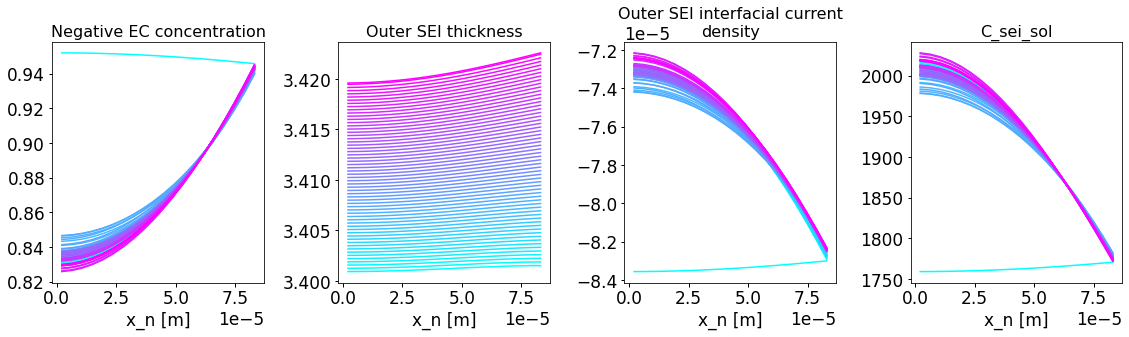

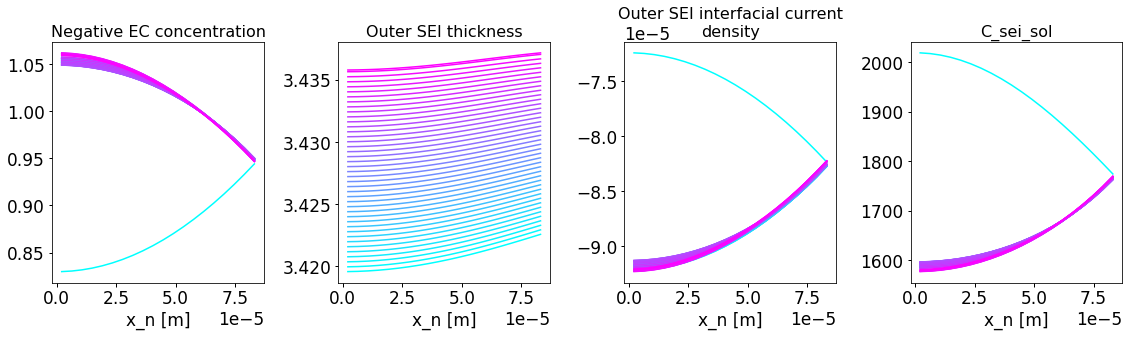

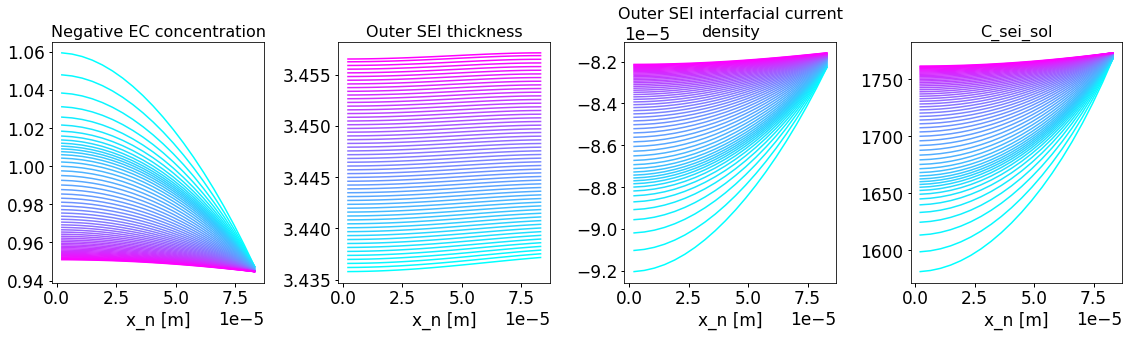

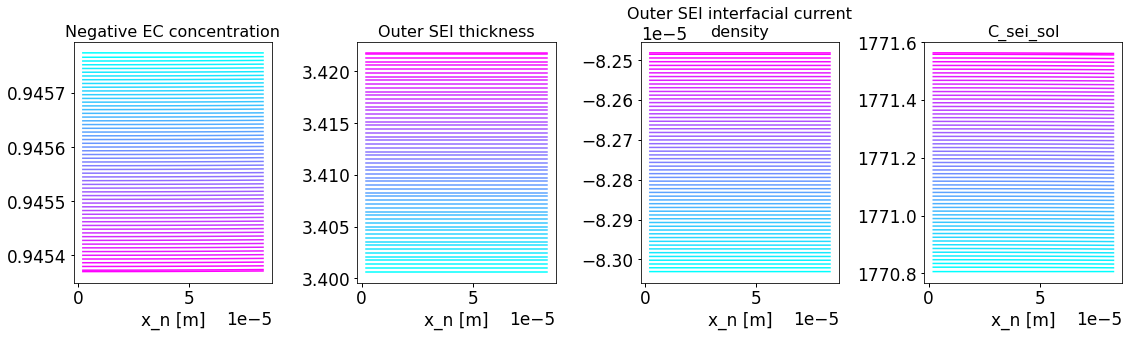

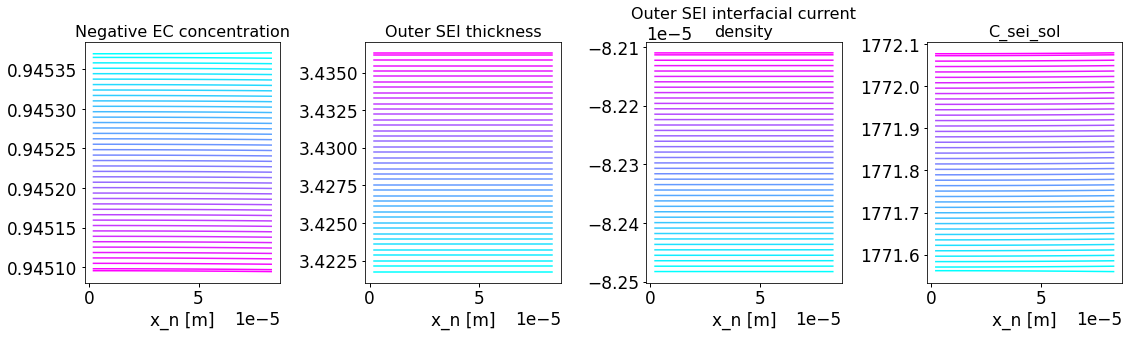

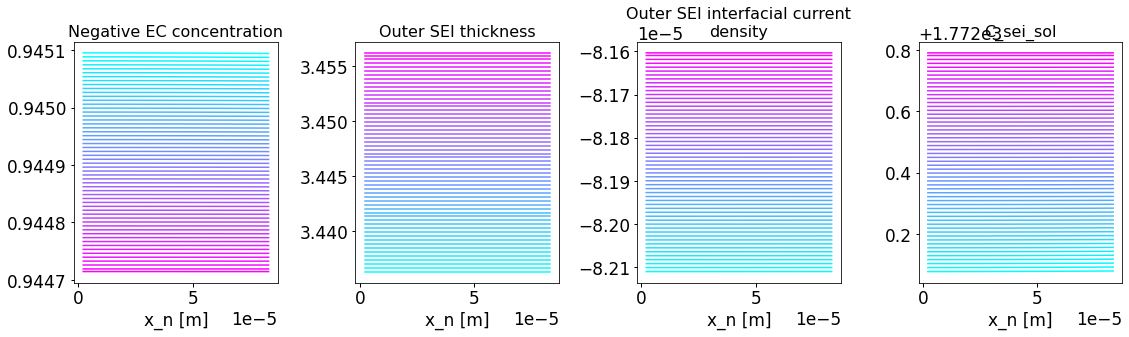

In [14]:
Plot_Loc_Var_sol(
    Sol_all_i[-1],
    ["x_n [m]","x_n [m]","x_n [m]","x_n [m]","x_n [m]"], 
    [
        "Negative EC concentration",     
        "Outer SEI thickness",  
        "Outer SEI interfacial current density",
        "C_sei_sol",          
        ],
    -1,0,'cool',17)
Plot_Loc_Var_sol(
    Sol_all_i[-1],
    ["x_n [m]","x_n [m]","x_n [m]","x_n [m]","x_n [m]"], 
    [
        "Negative EC concentration",     
        "Outer SEI thickness", 
        "Outer SEI interfacial current density",
        "C_sei_sol",  
        ],
    -1,1,'cool',17)
Plot_Loc_Var_sol(
    Sol_all_i[-1],
    ["x_n [m]","x_n [m]","x_n [m]","x_n [m]","x_n [m]"], 
    [
        "Negative EC concentration",     
        "Outer SEI thickness", 
        "Outer SEI interfacial current density",
        "C_sei_sol",  
        ],
    -1,2,'cool',17)
Plot_Loc_Var_sol(
    Sol_all_2[-1],
    ["x_n [m]","x_n [m]","x_n [m]","x_n [m]","x_n [m]"], 
    [
        "Negative EC concentration",     
        "Outer SEI thickness",  
        "Outer SEI interfacial current density",
        "C_sei_sol",          
        ],
    -1,0,'cool',17)
Plot_Loc_Var_sol(
    Sol_all_2[-1],
    ["x_n [m]","x_n [m]","x_n [m]","x_n [m]","x_n [m]"], 
    [
        "Negative EC concentration",     
        "Outer SEI thickness", 
        "Outer SEI interfacial current density",
        "C_sei_sol",  
        ],
    -1,1,'cool',17)
Plot_Loc_Var_sol(
    Sol_all_2[-1],
    ["x_n [m]","x_n [m]","x_n [m]","x_n [m]","x_n [m]"], 
    [
        "Negative EC concentration",     
        "Outer SEI thickness", 
        "Outer SEI interfacial current density",
        "C_sei_sol",  
        ],
    -1,2,'cool',17)

In [11]:
Sol_all_i[0].cycles[0].steps[0]
label = ["Discharge","Charge"]
output_variables3 = [
    "EC concentration",
    "EC source term (SEI)",
    "Minus div EC flux",
    "Minus div EC flux by diffusion",
    "Minus div EC flux by migration",
    "Minus div EC flux by Li+",
    #"Li+ source term refill",
]
quick_plot = pybamm.QuickPlot(
    [
        Sol_all_i[0].cycles[0].steps[0],
        Sol_all_i[0].cycles[0].steps[1],
        ], 
    output_variables3,label,
    variable_limits='fixed',time_unit='hours',n_rows=2,
    figsize = (12,9)) #     spatial_unit='mm',
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=1.6767879854117416, step=0.01676787985411741…

In [12]:
# Write all seperate excel files into a big file:
for i in Index:
    old_book = str(i) + '_' + book_name_xlsx
    #print(old_book)
    #open excel:
    #try:   # use try just in case some cases fail
    data_old = openpyxl.load_workbook(BasicPath + Target + old_book)   
    data_tar = openpyxl.load_workbook(BasicPath + Target + book_name_xlsx) 

    table_old = data_old.get_sheet_by_name(str(i))
    nrows_old = table_old.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数

    tar_sheet_name_xlsx = 'Results';
    table_tar = data_tar.get_sheet_by_name(tar_sheet_name_xlsx)
    nrows_tar = table_tar.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数
    list_old = [];
    #print(nrows_old,nrows_tar)
    for i in range(1,nrows_old+1):
        for j in range(1,ncolumns_old+1):
            list_old.append(table_old.cell(row=i,column=j).value)

    list_old = [list_old,]
    for i in range(1, len(list_old)+1):
            for j in range(1, len(list_old[i-1])+1):
                #print(i,j,list_old[i-1][j-1]    )
                table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
    data_tar.save(BasicPath + Target + book_name_xlsx) 
    data_tar.close()
    """ except:
        print("Something goes wrong!")
    else:
        pass """



C:\Users\rl1120\AppData\Local\Temp\ipykernel_6620\956488211.py:10: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  table_old = data_old.get_sheet_by_name(str(i))
C:\Users\rl1120\AppData\Local\Temp\ipykernel_6620\956488211.py:15: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  table_tar = data_tar.get_sheet_by_name(tar_sheet_name_xlsx)
